In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import os
from os import listdir
from os.path import join, isfile, isdir
from glob import glob

# PyTorch specific imports
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.utils import make_grid
from transformers import ViTForImageClassification, ViTFeatureExtractor, AdamW

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from PIL import Image
sns.set()
from tqdm import tqdm
%matplotlib inline

# **Data Management**
Data Management: The code loads multiple datasets from CSV files and refines them by removing irrelevant columns. It handles the datasets to prepare them for analysis by adjusting their structure.
File Management: It sets up directory paths and uses them to compile a list of image file paths for processing, demonstrating how the data is organized and accessed.
Data Analysis Preparation: Basic statistics about the image files and dataset composition are computed and displayed to provide insights into the dataset's scope and content.
This description offers a high-level overview of the tasks performed in the code, covering data handling, file management, and initial data analysis setup.

In [30]:
# reading the main dataset
all_xray_df = pd.read_csv("../input/chestxray8-dataframe/train_df.csv")
# dropping the 'No Finding' column
all_xray_df.drop(['No Finding'], axis=1, inplace=True)

print(all_xray_df.head())

        Image Index  Patient ID  Cardiomegaly  Emphysema  Effusion  Hernia  \
0  00000001_000.png           1             1          0         0       0   
1  00000001_001.png           1             1          1         0       0   
2  00000001_002.png           1             1          0         1       0   
3  00000002_000.png           2             0          0         0       0   
4  00000003_000.png           3             0          0         0       1   

   Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  Pleural_Thickening  \
0             0     0       0            0             0                   0   
1             0     0       0            0             0                   0   
2             0     0       0            0             0                   0   
3             0     0       0            0             0                   0   
4             0     0       0            0             0                   0   

   Pneumonia  Fibrosis  Edema  Consolidation  \
0 

In [31]:
data_dir1 = '../input/data/'
data_dir2 = '../input/chestxray8-dataframe/'

train_df = pd.read_csv(data_dir1 + 'Data_Entry_2017.csv')
image_label_map = pd.read_csv(data_dir2 + 'train_df.csv')
bad_labels = pd.read_csv(data_dir2 + 'cxr14_bad_labels.csv')

image_paths = glob(data_dir1 + 'images_*/images/*.png')
print(f'Total image files found: {len(image_paths)}')

# extracting the labels from the image_label_map dataframe
labels = image_label_map.columns[2:-1]
print("Labels:", labels)

# randomly sample 5000 rows from the image_label_map DataFrame
all_xray_df = all_xray_df.sample(n=5000, random_state=42)
print(all_xray_df.head())

Total image files found: 112120
Labels: Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'],
      dtype='object')
            Image Index  Patient ID  Cardiomegaly  Emphysema  Effusion  \
57468  00014285_001.png       14285             0          0         0   
896    00000213_005.png         213             0          0         0   
84198  00020767_000.png       20767             0          0         0   
69659  00017215_000.png       17215             0          0         0   
95650  00025234_013.png       25234             0          0         1   

       Hernia  Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  \
57468       0             0     0       0            0             0   
896         0             0     0       0            0             0   
84198       0             0     0       1    

In [32]:
labels = [
    'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
    'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
    'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'
]

image_label_map['Findings'] = image_label_map[labels].idxmax(axis=1)

# Plotting the histogram
fig = px.histogram(image_label_map, x="Findings", title="Primary Finding in Chest X-ray Images")
fig.update_xaxes(categoryorder="total descending")
fig.update_layout(xaxis_title="Conditions", yaxis_title="Number of Images", xaxis={'categoryorder':'total descending'})
fig.show()

Minority Class Identification: It defines specific classes as minorities based on their occurrence within the dataset.
Oversampling: For each minority class, it filters the dataset to obtain only the entries of that class, then oversamples these entries to increase their representation to a predefined target size.
Data Integration and Shuffling: The oversampled data is then integrated back into the original dataset, and the combined dataset is shuffled to ensure a uniform distribution of all classes.

In [33]:
import pandas as pd
from sklearn.utils import resample

# defining the minority classes (example based on your judgment or analysis)
minority_classes = ['Hernia', 'Fibrosis', 'Pneumonia']

oversampled_dfs = []

# filter and oversample each minority class
for class_name in minority_classes:
    
    class_df = all_xray_df[all_xray_df[class_name] == 1]
    
    # oversample this DataFrame
    oversampled_df = resample(class_df, 
                              replace=True,
                              n_samples=300,
                              random_state=123)
    
    oversampled_dfs.append(oversampled_df)

# concatenate the oversampled dataframes
oversampled_data = pd.concat(oversampled_dfs, axis=0)

In [34]:
# counting the occurrences of each class before and after oversampling
original_counts = all_xray_df[minority_classes].sum()
oversampled_counts = combined_data[minority_classes].sum()

fig = go.Figure(data=[
    go.Bar(name='Original', x=minority_classes, y=original_counts, marker_color='blue'),
    go.Bar(name='Oversampled', x=minority_classes, y=oversampled_counts, marker_color='red')
])

fig.update_layout(
    title='Class Distribution Before and After Oversampling',
    xaxis_title='Classes',
    yaxis_title='Count',
    barmode='group'
)

fig.show()

In [35]:
# defining the dataset class
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, oversample=False):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.oversample = oversample
        if self.oversample:
            self.oversample_minority_classes()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.dataframe.iloc[idx]['FilePath'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        label_columns = [col for col in self.dataframe.columns if col not in ['Image Index', 'Patient ID', 'FilePath']]
        labels = self.dataframe.iloc[idx][label_columns].values.astype(float)
        label_vector = torch.tensor(labels, dtype=torch.float32)
        return image, label_vector

    def oversample_minority_classes(self):
        label_columns = [col for col in self.dataframe.columns if col not in ['Image Index', 'Patient ID', 'FilePath']]
        condition_counts = self.dataframe[label_columns].sum().sort_values()
        max_samples = condition_counts.max()
        for condition, count in condition_counts.items():
            if count < max_samples:
                condition_df = self.dataframe[self.dataframe[condition] == 1]
                samples_to_add = condition_df.sample(max_samples - count, replace=True)
                self.dataframe = pd.concat([self.dataframe, samples_to_add], axis=0)
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

In [36]:
# image transformation based on NIH paper
transform = transforms.Compose([
    transforms.Resize(256),  # Resize to 256x256 first to ensure RandomCrop can work
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [37]:
# creating an instance for your dataset
dataset = ChestXrayDataset(dataframe=all_xray_df, image_dir='', transform=transform, oversample=True)

# splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# graph to visualize the dataset sizes
data = {'Dataset': ['Training', 'Validation'], 'Size': [len(train_dataset), len(val_dataset)]}
fig = px.bar(data, x='Dataset', y='Size', title='Training and Validation Dataset Sizes')
fig.show()

In [38]:
print("Length of train_dataset:", len(train_dataset))
print("Length of val_dataset:", len(val_dataset))

Length of train_dataset: 10888
Length of val_dataset: 2723


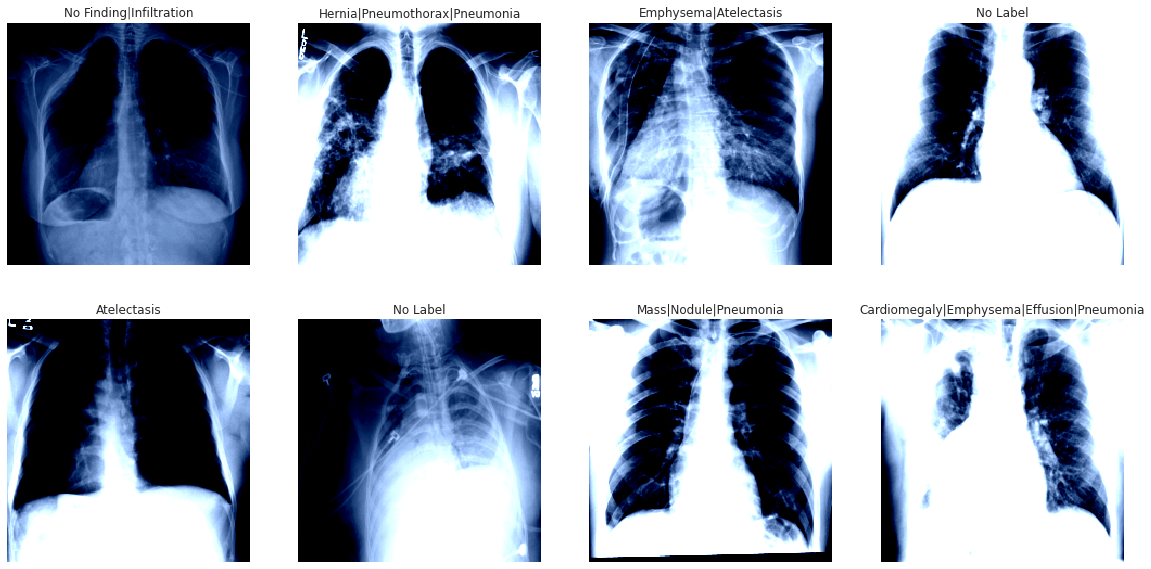

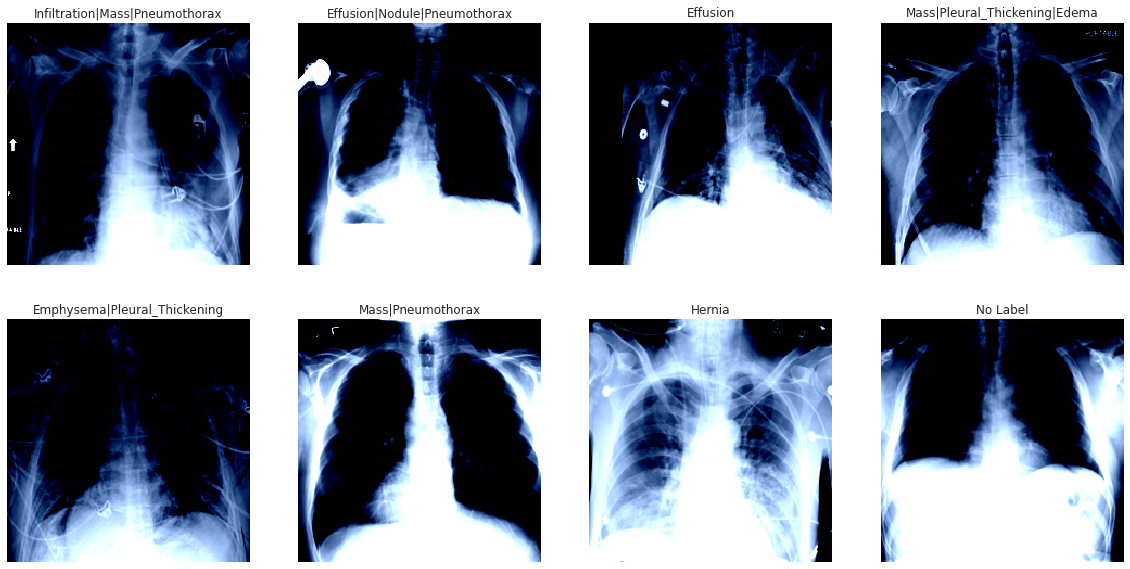

In [39]:
labels = [
    'Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
    'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
    'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'
]

def get_label(y):
    """
    Returns the appended label list of the given set.
    
    y (list or tensor): The one-hot vector list or tensor containing the label encoding.
    """
    ret_labels = []
    for i, idx in enumerate(y):
        if idx:
            ret_labels.append(labels[i])
    return '|'.join(ret_labels) if ret_labels else 'No Label'

def show_random_images_with_labels(dataset, num_images=4):
    """
    Displays a grid of random images from a given dataset with labels.
    
    Parameters:
    - dataset: PyTorch Dataset from which to draw images.
    - num_images: Number of random images to display.
    """
    indices = torch.randperm(len(dataset))[:num_images]
    fig = plt.figure(figsize=(20, 10))
    
    for i, index in enumerate(indices, start=1):
        image, label_vector = dataset[index]
        image_np = image.numpy().transpose((1, 2, 0))  # converting tensor to numpy and correct the axis
        label = get_label(label_vector.numpy())  # now, label_vector is converted to numpy or handled as a tensor
        
        ax = fig.add_subplot(2, num_images // 2, i)  # adjusting grid arrangement if num_images is not even
        ax.imshow(image_np, interpolation='nearest')
        ax.set_title(label)
        ax.axis('off')

    plt.show()

# visualize random images with labels -> training dataset
show_random_images_with_labels(train_dataset, num_images=8)

# visualize random images with labels -> validation dataset
show_random_images_with_labels(val_dataset, num_images=8)

In [40]:
# defining the models
def get_model(model_name, num_labels):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_labels)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_labels)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_labels)
    elif model_name == 'vit':
        model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_labels)
    else:
        raise ValueError("Invalid model name. Choose 'resnet50', 'densenet121', 'vgg16', or 'vit'.")
    return model



In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_data(dataframe, image_dir, model_name):
    """
    Load data into a PyTorch dataset with appropriate transformations.
    """
    transform = get_transforms(model_name)
    dataset = ChestXrayDataset(dataframe=dataframe, image_dir=image_dir, transform=transform)
    return dataset

def evaluate_model(model, val_loader):
    """
    Evaluate the model on the validation set and calculate AUC and accuracy.
    """
    model.eval()
    all_preds, all_labels = [], []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs)
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            preds_binary = predictions > 0.5
            total_correct += (preds_binary == labels).sum().item()
            total_samples += labels.numel()

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) if len(np.unique(all_labels[:, i])) > 1 else None
                  for i in range(all_labels.shape[1])]
    mean_auc = np.nanmean([auc for auc in auc_scores if auc is not None])
    accuracy = total_correct / total_samples
    return auc_scores, mean_auc, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5, min_delta=0.001):
    """
    Train the model with early stopping based on validation AUC.
    """
    model.to(device)
    best_auc, best_acc = 0, 0
    epochs_no_improve = 0
    best_model_wts = model.state_dict()
    epoch_losses, epoch_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_preds, total_preds = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs).data > 0.5
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.numel()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_preds
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        # evaluate the model on the validation set
        val_aucs, mean_auc, val_accuracy = evaluate_model(model, val_loader)
        y_true, y_pred = get_labels_and_predictions(val_loader, model, device)
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}, Val AUC: {mean_auc:.4f}, Val Acc: {val_accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')

        if mean_auc > best_auc + min_delta:
            best_auc, best_acc = mean_auc, val_accuracy
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break

    model.load_state_dict(best_model_wts)
    return model, epoch_losses, epoch_accuracies, best_auc, best_acc

In [42]:
def train_vit_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5, min_delta=0.001):
    """
    Train a Vision Transformer (ViT) model with early stopping.
    
    Args:
        model: The ViT model to be trained.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        device: Device to train on ('cuda' or 'cpu').
        num_epochs: Number of epochs to train for.
        patience: Patience for early stopping.
        min_delta: Minimum change in validation loss to qualify as an improvement.
        
    Returns:
        A tuple containing the trained model, epoch-wise losses, accuracies, best AUC, and best accuracy.
    """
    model.to(device)
    model.train()

    best_auc = 0
    best_acc = 0
    epochs_no_improve = 0
    best_model_wts = model.state_dict()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs.logits).data > 0.5 
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.numel()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_preds
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        
        val_aucs, mean_auc, val_accuracy = evaluate_vit_model(model, val_loader, device)
        auc_scores, mean_auc, final_val_acc = evaluate_vit_model(model, val_loader, device)
        y_true, y_pred = get_labels_and_predictions_vit(val_loader, model, device)
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}, Val AUC: {mean_auc:.4f}, Val Acc: {val_accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')

        if mean_auc > best_auc + min_delta:
            best_auc = mean_auc
            best_acc = val_accuracy
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break

    model.load_state_dict(best_model_wts)
    return model, epoch_losses, epoch_accuracies, best_auc, best_acc

def evaluate_vit_model(model, val_loader, device):
    """
    Evaluate a Vision Transformer (ViT) model on a validation set.
    
    Args:
        model: The ViT model to be evaluated.
        val_loader: DataLoader for the validation set.
        device: Device to evaluate on ('cuda' or 'cpu').
        
    Returns:
        AUC scores for each label, mean AUC, and accuracy.
    """
    model.eval()
    all_preds = []
    all_labels = []
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs.logits)
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            preds_binary = predictions > 0.5
            total_correct += (preds_binary == labels).sum().item()
            total_samples += labels.numel()

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) if len(np.unique(all_labels[:, i])) > 1 else None
                  for i in range(all_labels.shape[1])]
    mean_auc = np.nanmean([auc for auc in auc_scores if auc is not None])
    accuracy = total_correct / total_samples
    return auc_scores, mean_auc, accuracy

In [43]:
labels = all_xray_df[['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']].values
label_tensor = torch.tensor(labels, dtype=torch.float32)
class_counts = label_tensor.sum(axis=0)
total_samples = label_tensor.shape[0]
class_weights = total_samples / (class_counts * len(labels[0]))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).clone().detach()  # Adjusted line
class_weights_tensor = class_weights_tensor.to(device)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [44]:
def get_labels_and_predictions(loader, model, device, use_logits=False):
    """
    Extract labels and predictions for a given DataLoader and model.
    
    Args:
        loader: DataLoader containing the dataset for evaluation.
        model: The trained model for prediction.
        device: The device on which the model is deployed ('cuda' or 'cpu').
        use_logits: A boolean flag indicating if the model outputs logits (e.g., Vision Transformer).
        
    Returns:
        Numpy arrays of true labels and model predictions.
    """
    model.eval()
    all_labels, all_predictions = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.logits if use_logits else outputs  # Use logits if specified

            predictions = torch.sigmoid(outputs)
            predictions = (predictions > 0.5).float()  # Convert probabilities to binary output

            all_labels.append(labels.cpu())
            all_predictions.append(predictions.cpu())

    all_labels = torch.cat(all_labels, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return all_labels.numpy(), all_predictions.numpy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_to_train = ['resnet50', 'vgg16', 'densenet121']
trained_models = {}
models_metrics = {}

def save_model(model, path):
    torch.save(model.state_dict(), path)

def train_and_evaluate(model_name):
    print(f"Training and evaluating {model_name}")
    model = get_model(model_name, num_labels=14)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

    trained_model, losses, accuracies, best_auc, best_acc = train_model(
        model=model, 
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion, 
        optimizer=optimizer, 
        num_epochs=10,
        patience=3,
        min_delta=0.001,
        device=device
    )
    
    auc_scores, mean_auc, final_val_acc = evaluate_model(trained_model, val_loader)
    y_true, y_pred = get_labels_and_predictions(val_loader, trained_model, device)  # Ensure this function handles 'device'
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"AUC Scores for {model_name}: {auc_scores}")
    print(f"Mean AUC for {model_name}: {mean_auc}")
    print(f"Final Validation Accuracy for {model_name}: {final_val_acc}")
    print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

    save_model_path = f"{model_name}_best.pth"
    save_model(trained_model, save_model_path)

    return {
        'trained_model': trained_model,
        'losses': losses,
        'accuracies': accuracies,
        'best_auc': best_auc,
        'best_acc': best_acc,
        'final_auc_scores': auc_scores,
        'mean_auc': mean_auc,
        'final_val_acc': final_val_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

for model_name in models_to_train:
    try:
        model_metrics = train_and_evaluate(model_name)
        models_metrics[model_name] = model_metrics
        trained_models[model_name] = model_metrics['trained_model']
    except Exception as e:
        print(f"An error occurred while training {model_name}: {str(e)}")


Training and evaluating resnet50
Epoch 1/10, Train Loss: 1.2566, Train Acc: 0.87, Val AUC: 0.7503, Val Acc: 0.83, Precision: 0.38, Recall: 0.35, F1-Score: 0.30
Epoch 2/10, Train Loss: 0.9028, Train Acc: 0.89, Val AUC: 0.7706, Val Acc: 0.86, Precision: 0.57, Recall: 0.23, F1-Score: 0.31
Epoch 3/10, Train Loss: 0.7660, Train Acc: 0.89, Val AUC: 0.8293, Val Acc: 0.90, Precision: 0.73, Recall: 0.36, F1-Score: 0.45
Epoch 4/10, Train Loss: 0.7045, Train Acc: 0.90, Val AUC: 0.8354, Val Acc: 0.90, Precision: 0.69, Recall: 0.38, F1-Score: 0.46
Epoch 5/10, Train Loss: 0.6395, Train Acc: 0.90, Val AUC: 0.8279, Val Acc: 0.89, Precision: 0.75, Recall: 0.35, F1-Score: 0.45
Epoch 6/10, Train Loss: 0.5623, Train Acc: 0.91, Val AUC: 0.8660, Val Acc: 0.91, Precision: 0.85, Recall: 0.42, F1-Score: 0.52
Epoch 7/10, Train Loss: 0.5524, Train Acc: 0.91, Val AUC: 0.8777, Val Acc: 0.91, Precision: 0.88, Recall: 0.48, F1-Score: 0.59
Epoch 8/10, Train Loss: 0.4580, Train Acc: 0.92, Val AUC: 0.8880, Val Acc: 0.9

In [ ]:
def get_labels_and_predictions_vit(loader, model, device, use_logits=False):
    model.eval()
    all_labels, all_predictions = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.logits if use_logits else outputs  # Use logits if specified

            predictions = torch.sigmoid(outputs.logits)
            predictions = (predictions > 0.5).float()  # Convert probabilities to binary output

            all_labels.append(labels.cpu())
            all_predictions.append(predictions.cpu())

    all_labels = torch.cat(all_labels, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return all_labels.numpy(), all_predictions.numpy()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_to_train_vit = ['vit']
trained_models_vit = {}
models_metrics_vit = {}

def save_model(model, path):
    torch.save(model.state_dict(), path)

def train_and_evaluate_vit(model_name):
    print(f"Training and evaluating {model_name}")

    model = get_model(model_name, num_labels=14) 
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

    trained_model, losses, accuracies, best_auc, best_acc = train_vit_model(
        model=model, 
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion, 
        optimizer=optimizer, 
        device=device, 
        num_epochs=10,
        patience=3,
        min_delta=0.001
    )

    auc_scores, mean_auc, final_val_acc = evaluate_vit_model(trained_model, val_loader, device)
    y_true, y_pred = get_labels_and_predictions_vit(val_loader, trained_model, device)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"AUC Scores for {model_name}: {auc_scores}")
    print(f"Mean AUC for {model_name}: {mean_auc}")
    print(f"Final Validation Accuracy for {model_name}: {final_val_acc}")
    print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


    save_model_path = f"{model_name}_best.pth"
    save_model(trained_model, save_model_path)

    trained_models_vit[model_name] = trained_model
    models_metrics_vit[model_name] = {
        'losses': losses,
        'accuracies': accuracies,
        'best_auc': best_auc,
        'best_acc': best_acc,
        'final_auc_scores': auc_scores,
        'mean_auc': mean_auc,
        'final_val_acc': final_val_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    return models_metrics_vit[model_name]

for model_name in models_to_train_vit:
    train_and_evaluate_vit(model_name)